# E-Commerce Review Classification using PyTorch

This notebook implements:
1. **Product Category Classification** - Multiclass classification for 10 product categories
2. **Fake Review Detection** - Binary classification to identify fake vs genuine reviews
3. **Word Cloud Generation** - Visualization of influential words in fake reviews

**Architecture**: Forward-pass Neural Network with:
- Hidden Layer 1: 64 neurons + ReLU
- Hidden Layer 2: 32 neurons + ReLU

## 1. Setup and Imports

In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load and Explore Dataset

In [ ]:
# Load the dataset
df = pd.read_csv('fake_reviews_dataset.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
df.head()

Dataset Shape: (40432, 4)

Columns: ['category', 'rating', 'label', 'text_']

First 5 rows:


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [ ]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Drop rows with missing text
df = df.dropna(subset=['text_'])
print(f"\nDataset shape after dropping nulls: {df.shape}")

Missing values:
category    0
rating      0
label       0
text_       0
dtype: int64

Dataset shape after dropping nulls: (40432, 4)


Product Categories:
category
Kindle_Store_5                  4730
Books_5                         4370
Pet_Supplies_5                  4254
Home_and_Kitchen_5              4056
Electronics_5                   3988
Sports_and_Outdoors_5           3946
Tools_and_Home_Improvement_5    3858
Clothing_Shoes_and_Jewelry_5    3848
Toys_and_Games_5                3794
Movies_and_TV_5                 3588
Name: count, dtype: int64


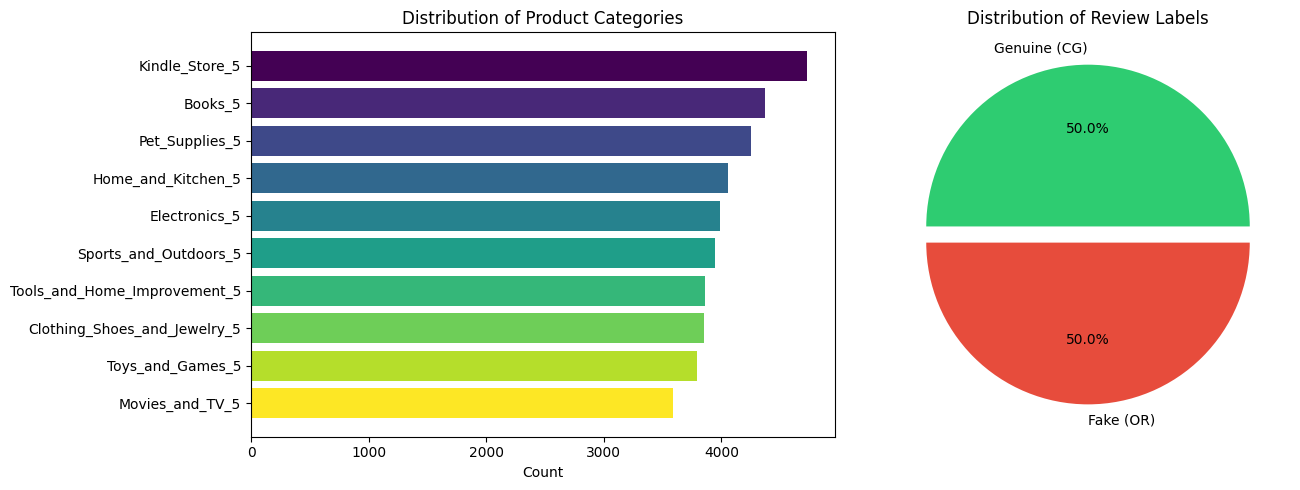

In [ ]:
# Explore categories
print("Product Categories:")
print(df['category'].value_counts())

# Visualize category distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Category distribution
category_counts = df['category'].value_counts()
colors = plt.cm.viridis(np.linspace(0, 1, len(category_counts)))
axes[0].barh(category_counts.index, category_counts.values, color=colors)
axes[0].set_xlabel('Count')
axes[0].set_title('Distribution of Product Categories')
axes[0].invert_yaxis()

# Label distribution (Fake vs Genuine)
label_counts = df['label'].value_counts()
label_names = ['Genuine (CG)' if l == 'CG' else 'Fake (OR)' for l in label_counts.index]
axes[1].pie(label_counts.values, labels=label_names, autopct='%1.1f%%', 
            colors=['#2ecc71', '#e74c3c'], explode=(0.05, 0.05))
axes[1].set_title('Distribution of Review Labels')

plt.tight_layout()
plt.savefig('data_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Text Preprocessing with spaCy

In [25]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
 
    doc = nlp(text.lower())
    
    tokens = [
        token.lemma_ for token in doc 
        if not token.is_stop 
        and not token.is_punct 
        and token.is_alpha 
        and len(token.text) > 2
    ]
    
    return ' '.join(tokens)

sample_text = df['text_'].iloc[0]
print(f"Original: {sample_text[:200]}...")
print(f"\nProcessed: {preprocess_text(sample_text)[:200]}...")

Original: Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty...

Processed: love sturdy comfortable love pretty...


In [26]:
# Apply preprocessing to all reviews
df['processed_text'] = df['text_'].apply(preprocess_text)
print("Preprocessing complete!")

# Remove empty processed texts
df = df[df['processed_text'].str.len() > 0]
print(f"Dataset shape after preprocessing: {df.shape}")

Preprocessing complete!
Dataset shape after preprocessing: (40429, 5)


## 4. Feature Engineering with TF-IDF

In [52]:
category_encoder = LabelEncoder()
df['category_encoded'] = category_encoder.fit_transform(df['category'])

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

print("Category mapping:")
for i, cat in enumerate(category_encoder.classes_):
    print(f"  {i}: {cat}")

print(f"\nLabel mapping:")
for i, lab in enumerate(label_encoder.classes_):
    print(f"  {i}: {lab} ({'Genuine' if lab == 'CG' else 'Fake'})")

Category mapping:
  0: Books_5
  1: Clothing_Shoes_and_Jewelry_5
  2: Electronics_5
  3: Home_and_Kitchen_5
  4: Kindle_Store_5
  5: Movies_and_TV_5
  6: Pet_Supplies_5
  7: Sports_and_Outdoors_5
  8: Tools_and_Home_Improvement_5
  9: Toys_and_Games_5

Label mapping:
  0: CG (Genuine)
  1: OR (Fake)


In [53]:
# Create TF-IDF vectors
MAX_FEATURES = 5000

tfidf_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

print(f"TF-IDF Shape: {X_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

TF-IDF Shape: (40429, 5000)
Vocabulary size: 5000


In [54]:
# Prepare features and labels
X = X_tfidf.toarray().astype(np.float32)
y_category = df['category_encoded'].values
y_fake = df['label_encoded'].values

# Split data: 70% train, 15% validation, 15% test
X_train, X_temp, y_cat_train, y_cat_temp, y_fake_train, y_fake_temp = train_test_split(
    X, y_category, y_fake, test_size=0.3, random_state=SEED, stratify=y_category
)

X_val, X_test, y_cat_val, y_cat_test, y_fake_val, y_fake_test = train_test_split(
    X_temp, y_cat_temp, y_fake_temp, test_size=0.5, random_state=SEED, stratify=y_cat_temp
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 28300 samples
Validation set: 6064 samples
Test set: 6065 samples


## 5. PyTorch Dataset and DataLoader

In [55]:
class ReviewDataset(Dataset):    
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ReviewDatasetBinary(Dataset):    
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 32

# Dataloaders for Category Classification
train_dataset_cat = ReviewDataset(X_train, y_cat_train)
val_dataset_cat = ReviewDataset(X_val, y_cat_val)
test_dataset_cat = ReviewDataset(X_test, y_cat_test)

train_loader_cat = DataLoader(train_dataset_cat, batch_size=BATCH_SIZE, shuffle=True)
val_loader_cat = DataLoader(val_dataset_cat, batch_size=BATCH_SIZE, shuffle=False)
test_loader_cat = DataLoader(test_dataset_cat, batch_size=BATCH_SIZE, shuffle=False)

# Dataloaders for Fake Detection
train_dataset_fake = ReviewDatasetBinary(X_train, y_fake_train)
val_dataset_fake = ReviewDatasetBinary(X_val, y_fake_val)
test_dataset_fake = ReviewDatasetBinary(X_test, y_fake_test)

train_loader_fake = DataLoader(train_dataset_fake, batch_size=BATCH_SIZE, shuffle=True)
val_loader_fake = DataLoader(val_dataset_fake, batch_size=BATCH_SIZE, shuffle=False)
test_loader_fake = DataLoader(test_dataset_fake, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of batches - Train: {len(train_loader_cat)}, Val: {len(val_loader_cat)}, Test: {len(test_loader_cat)}")

Number of batches - Train: 885, Val: 190, Test: 190


## 6. Neural Network Architecture

In [56]:
class CategoryClassifier(nn.Module):
    
    def __init__(self, input_dim, num_classes=10):
        super(CategoryClassifier, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


class FakeReviewDetector(nn.Module):
    
    def __init__(self, input_dim):
        super(FakeReviewDetector, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


# Initialize models
input_dim = X_train.shape[1]
num_categories = len(category_encoder.classes_)

category_model = CategoryClassifier(input_dim, num_categories).to(device)
fake_model = FakeReviewDetector(input_dim).to(device)

print("Category Classification Model:")
print(category_model)
print(f"\nTotal parameters: {sum(p.numel() for p in category_model.parameters()):,}")

print("\nFake Review Detection Model:")
print(fake_model)
print(f"\nTotal parameters: {sum(p.numel() for p in fake_model.parameters()):,}")

Category Classification Model:
CategoryClassifier(
  (fc1): Linear(in_features=5000, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Total parameters: 322,474

Fake Review Detection Model:
FakeReviewDetector(
  (fc1): Linear(in_features=5000, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Total parameters: 322,177


## 7. Training Functions

In [57]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        
        # Calculate loss
        if outputs.dim() == 1 or outputs.shape[1] == 1:  # Binary classification
            outputs = outputs.squeeze()
            loss = criterion(outputs, y_batch)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
        else:  # Multiclass classification
            loss = criterion(outputs, y_batch)
            _, predicted = torch.max(outputs, 1)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    
    return total_loss / len(dataloader), correct / total


def evaluate(model, dataloader, criterion, device):
    """Evaluate model on validation/test set"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            
            if outputs.dim() == 1 or outputs.shape[1] == 1:  # Binary classification
                outputs = outputs.squeeze()
                loss = criterion(outputs, y_batch)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
            else:  # Multiclass classification
                loss = criterion(outputs, y_batch)
                _, predicted = torch.max(outputs, 1)
            
            total_loss += loss.item()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    return total_loss / len(dataloader), correct / total, np.array(all_preds), np.array(all_labels)


def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=50, patience=10):
    """Full training loop with early stopping"""
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_losses, val_losses, train_accs, val_accs

## 8. Visualization Functions

In [62]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs, title, save_path):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss curves
    axes[0].plot(train_losses, label='Training Loss', color='#3498db', linewidth=2)
    axes[0].plot(val_losses, label='Validation Loss', color='#e74c3c', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{title} - Loss Curves')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[1].plot(train_accs, label='Training Accuracy', color='#3498db', linewidth=2)
    axes[1].plot(val_accs, label='Validation Accuracy', color='#e74c3c', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title(f'{title} - Accuracy Curves')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_confusion_matrix(y_true, y_pred, classes, title, save_path):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10) if len(classes) > 5 else (8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{title} - Confusion Matrix')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def print_classification_metrics(y_true, y_pred, classes, title):
    print(f"{title} - Classification Metrics")
    
    accuracy = accuracy_score(y_true, y_pred)
    
    if len(classes) == 2:  # Binary classification
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
    else:  # Multiclass classification
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\nOverall Metrics:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# Task 1: Product Category Classification

In [59]:
print("TASK 1: PRODUCT CATEGORY CLASSIFICATION")

# Re-initialize model for fresh training
category_model = CategoryClassifier(input_dim, num_categories).to(device)

# Define loss function and optimizer
criterion_cat = nn.CrossEntropyLoss()
optimizer_cat = optim.Adam(category_model.parameters(), lr=0.001)

print(f"\nTraining Category Classification Model...")
print(f"Number of categories: {num_categories}")
print(f"Input dimensions: {input_dim}")
print()

TASK 1: PRODUCT CATEGORY CLASSIFICATION

Training Category Classification Model...
Number of categories: 10
Input dimensions: 5000



In [60]:
# Train the model
train_losses_cat, val_losses_cat, train_accs_cat, val_accs_cat = train_model(
    category_model, train_loader_cat, val_loader_cat, 
    criterion_cat, optimizer_cat, device, 
    epochs=20, patience=10
)

Epoch 5/20 | Train Loss: 0.4688 | Val Loss: 0.7471 | Train Acc: 0.8428 | Val Acc: 0.7604
Epoch 10/20 | Train Loss: 0.2645 | Val Loss: 0.9950 | Train Acc: 0.9108 | Val Acc: 0.7457

Early stopping at epoch 13


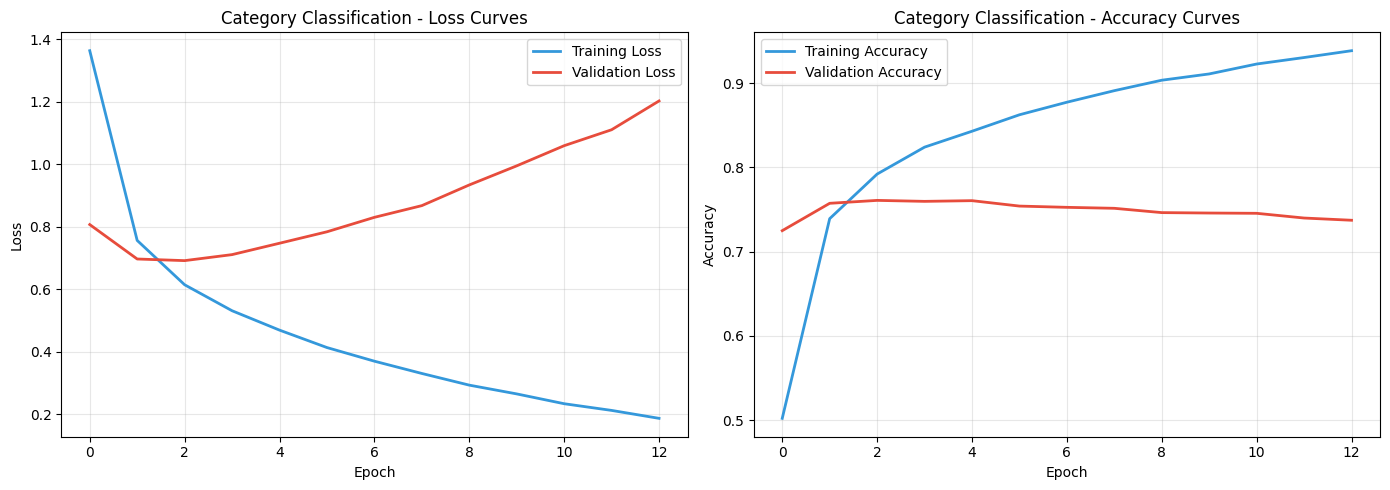

In [63]:
# Plot training curves for category classification
plot_training_curves(
    train_losses_cat, val_losses_cat, train_accs_cat, val_accs_cat,
    'Category Classification', 'category_training_curves.png'
)

In [64]:
# Evaluate on test set
test_loss_cat, test_acc_cat, y_pred_cat, y_true_cat = evaluate(
    category_model, test_loader_cat, criterion_cat, device
)

# Print metrics
category_names = list(category_encoder.classes_)
cat_metrics = print_classification_metrics(y_true_cat, y_pred_cat, category_names, 'Category Classification')

Category Classification - Classification Metrics

Overall Metrics:
  Accuracy:  0.7406
  Precision: 0.7418
  Recall:    0.7406
  F1-Score:  0.7411

Detailed Classification Report:
                              precision    recall  f1-score   support

                     Books_5       0.69      0.69      0.69       656
Clothing_Shoes_and_Jewelry_5       0.80      0.79      0.80       577
               Electronics_5       0.79      0.77      0.78       598
          Home_and_Kitchen_5       0.67      0.64      0.65       608
              Kindle_Store_5       0.75      0.74      0.74       710
             Movies_and_TV_5       0.88      0.88      0.88       538
              Pet_Supplies_5       0.84      0.83      0.83       638
       Sports_and_Outdoors_5       0.57      0.61      0.59       592
Tools_and_Home_Improvement_5       0.67      0.69      0.68       579
            Toys_and_Games_5       0.77      0.78      0.78       569

                    accuracy                    

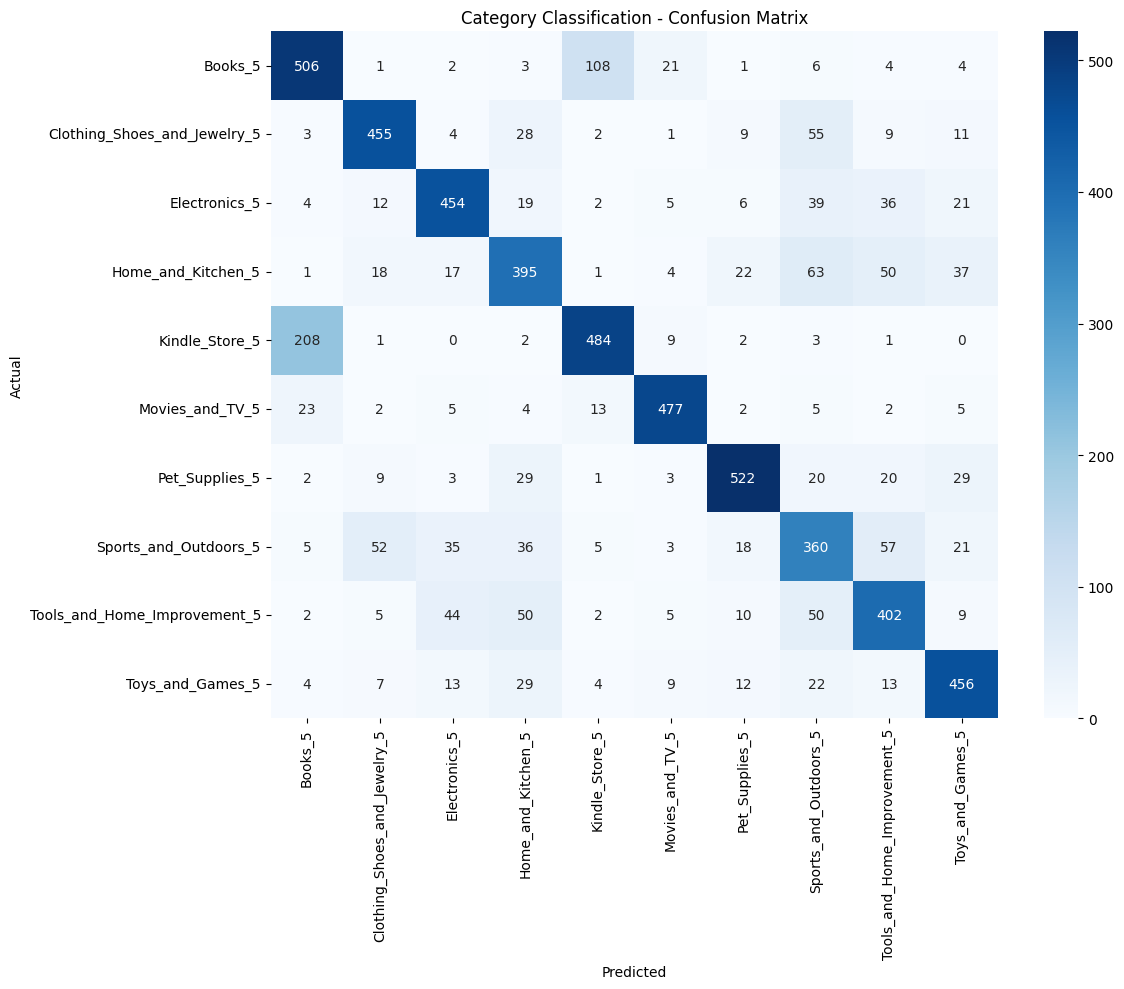

In [38]:
# Plot confusion matrix for category classification
plot_confusion_matrix(
    y_true_cat, y_pred_cat, category_names,
    'Category Classification', 'category_confusion_matrix.png'
)

# Task 2: Fake Review Detection

In [67]:
# Re-initialize model for fresh training
fake_model = FakeReviewDetector(input_dim).to(device)

# Define loss function and optimizer
criterion_fake = nn.BCEWithLogitsLoss()
optimizer_fake = optim.Adam(fake_model.parameters(), lr=0.001)

print(f"\nTraining Fake Review Detection Model...")
print(f"Binary classification: Genuine (CG=0) vs Fake (OR=1)")
print(f"Input dimensions: {input_dim}")
print()


Training Fake Review Detection Model...
Binary classification: Genuine (CG=0) vs Fake (OR=1)
Input dimensions: 5000



In [72]:
# Train the model
train_losses_fake, val_losses_fake, train_accs_fake, val_accs_fake = train_model(
    fake_model, train_loader_fake, val_loader_fake,
    criterion_fake, optimizer_fake, device,
    epochs=20, patience=10
)

Epoch 5/20 | Train Loss: 0.0105 | Val Loss: 1.0438 | Train Acc: 0.9965 | Val Acc: 0.8626
Epoch 10/20 | Train Loss: 0.0074 | Val Loss: 1.1770 | Train Acc: 0.9976 | Val Acc: 0.8646

Early stopping at epoch 11


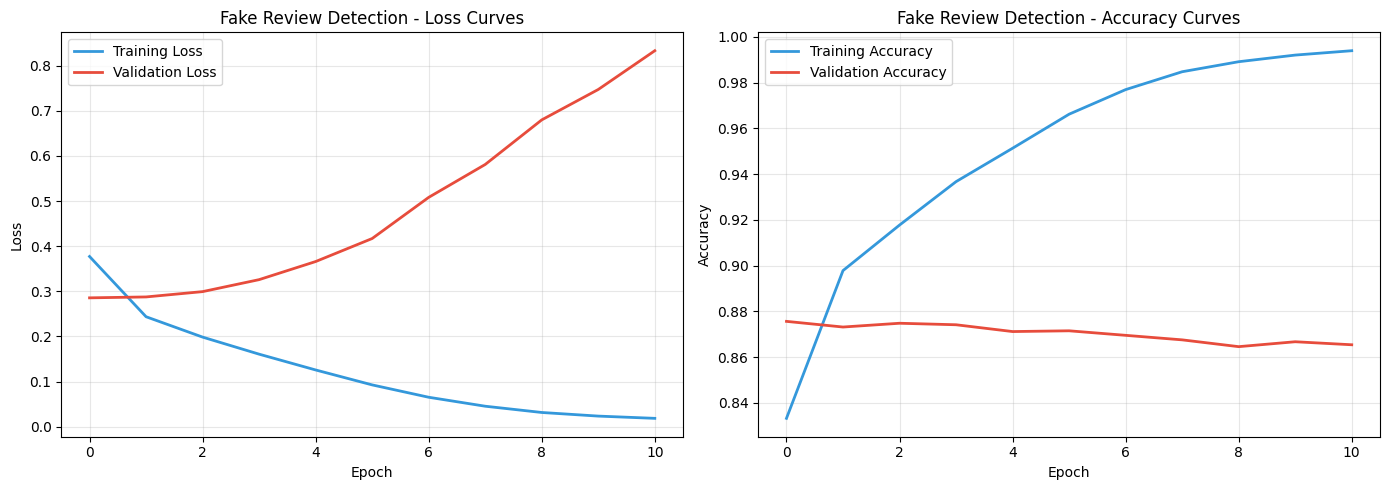

In [69]:
# Plot training curves for fake review detection
plot_training_curves(
    train_losses_fake, val_losses_fake, train_accs_fake, val_accs_fake,
    'Fake Review Detection', 'fake_detection_training_curves.png'
)

In [70]:
# Evaluate on test set
test_loss_fake, test_acc_fake, y_pred_fake, y_true_fake = evaluate(
    fake_model, test_loader_fake, criterion_fake, device
)

# Print metrics
label_names = ['Genuine (CG)', 'Fake (OR)']
fake_metrics = print_classification_metrics(y_true_fake, y_pred_fake, label_names, 'Fake Review Detection')

Fake Review Detection - Classification Metrics

Overall Metrics:
  Accuracy:  0.8595
  Precision: 0.8528
  Recall:    0.8609
  F1-Score:  0.8569

Detailed Classification Report:
              precision    recall  f1-score   support

Genuine (CG)       0.87      0.86      0.86      3103
   Fake (OR)       0.85      0.86      0.86      2962

    accuracy                           0.86      6065
   macro avg       0.86      0.86      0.86      6065
weighted avg       0.86      0.86      0.86      6065



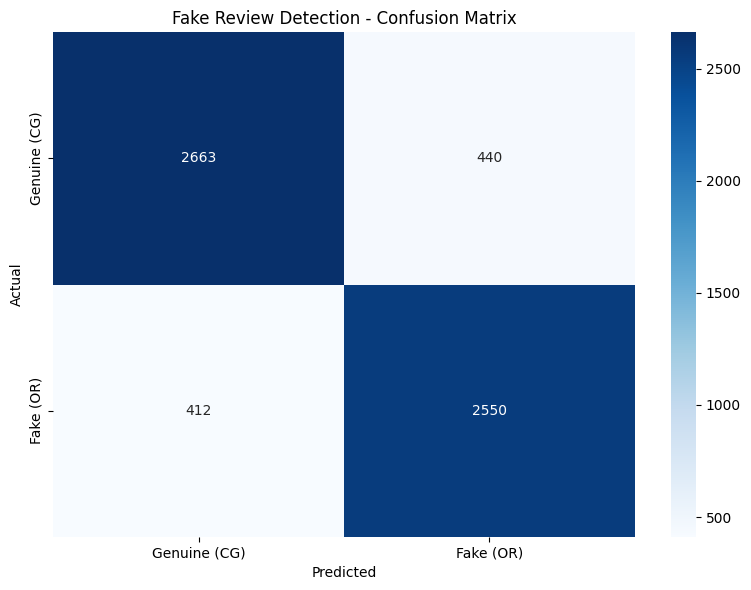

In [71]:
# Plot confusion matrix for fake review detection
plot_confusion_matrix(
    y_true_fake, y_pred_fake, label_names,
    'Fake Review Detection', 'fake_detection_confusion_matrix.png'
)

# Task 3: Word Cloud Generation for Fake Reviews

In [44]:
print("="*60)
print("TASK 3: WORD CLOUD GENERATION")
print("="*60)

TASK 3: WORD CLOUD GENERATION


In [45]:
# Method 1: Extract influential words from model weights
# Get the weights from the first layer of the fake detection model
first_layer_weights = fake_model.fc1.weight.data.cpu().numpy()

# Calculate feature importance as mean absolute weight across all neurons
feature_importance = np.mean(np.abs(first_layer_weights), axis=0)

# Get vocabulary from TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create importance dictionary
importance_dict = {feature_names[i]: float(feature_importance[i]) for i in range(len(feature_names))}

# Get top 100 most important features
top_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:100]
print(f"Top 20 influential words for classification:")
for word, importance in top_features[:20]:
    print(f"  {word}: {importance:.6f}")

Top 20 influential words for classification:
  recommend enjoy: 0.238880
  large head: 0.237110
  thing wish: 0.227622
  huge fan: 0.226339
  reason give: 0.225986
  plastic part: 0.224934
  problem come: 0.224791
  developed plot: 0.210327
  piece sturdy: 0.208364
  mystery good: 0.207020
  christmas absolutely: 0.204212
  heavy expect: 0.202541
  light output: 0.201526
  bright bright: 0.197571
  nice white: 0.196104
  lot heart: 0.194199
  comfortable comfortable: 0.193800
  strong like: 0.193133
  character complex: 0.192970
  pretty straight: 0.192522


In [46]:
# Method 2: Analyze TF-IDF weights for fake vs genuine reviews
# Get fake reviews
fake_reviews = df[df['label'] == 'OR']['processed_text']
genuine_reviews = df[df['label'] == 'CG']['processed_text']

# Calculate average TF-IDF for fake and genuine reviews
fake_tfidf = tfidf_vectorizer.transform(fake_reviews).toarray()
genuine_tfidf = tfidf_vectorizer.transform(genuine_reviews).toarray()

# Average TF-IDF scores
fake_avg = np.mean(fake_tfidf, axis=0)
genuine_avg = np.mean(genuine_tfidf, axis=0)

# Difference: words more common in fake reviews
diff = fake_avg - genuine_avg

# Create dictionary of words more associated with fake reviews
fake_word_importance = {}
for i, word in enumerate(feature_names):
    if diff[i] > 0:  # Word more common in fake reviews
        fake_word_importance[word] = float(diff[i])

print(f"\nTop 20 words more common in fake reviews:")
top_fake_words = sorted(fake_word_importance.items(), key=lambda x: x[1], reverse=True)[:20]
for word, score in top_fake_words:
    print(f"  {word}: {score:.6f}")


Top 20 words more common in fake reviews:
  get: 0.007925
  come: 0.006337
  need: 0.005991
  well: 0.005915
  end: 0.005874
  make: 0.005190
  know: 0.004765
  work: 0.004624
  day: 0.004607
  help: 0.004352
  far: 0.004270
  take: 0.004185
  go: 0.004099
  time: 0.004080
  find: 0.004049
  life: 0.004016
  run: 0.003918
  leave: 0.003808
  water: 0.003790
  right: 0.003783


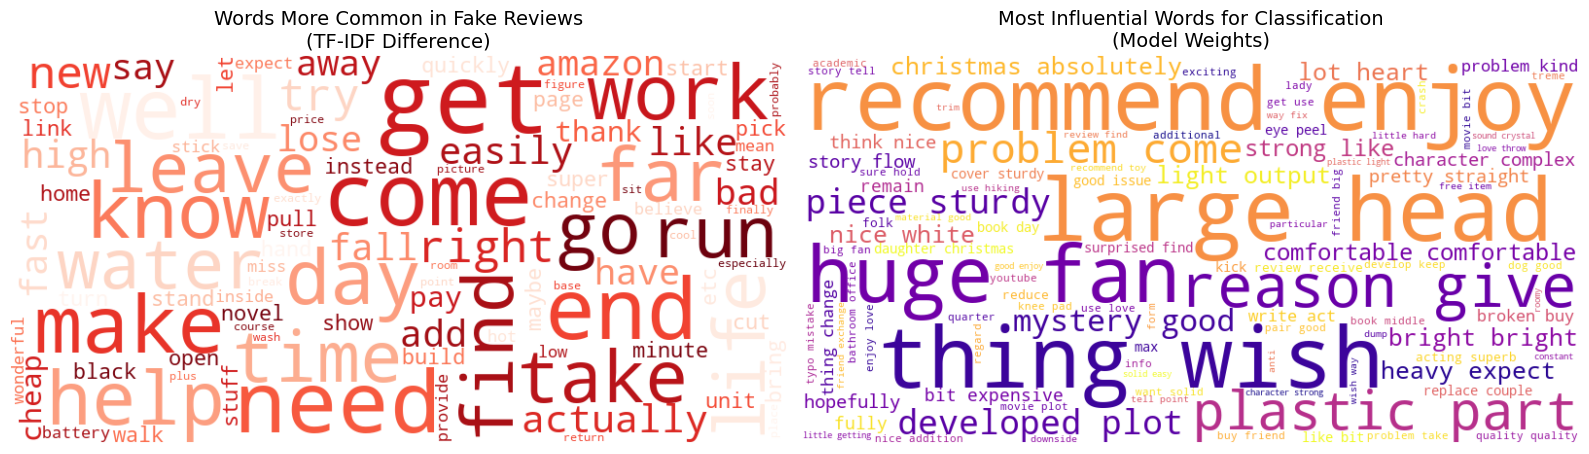

In [47]:
# Generate Word Cloud for fake reviews
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Word Cloud 1: Based on TF-IDF difference
wordcloud_tfidf = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='Reds',
    max_words=100,
    max_font_size=100,
    random_state=SEED
).generate_from_frequencies(fake_word_importance)

axes[0].imshow(wordcloud_tfidf, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Words More Common in Fake Reviews\n(TF-IDF Difference)', fontsize=14)

# Word Cloud 2: Based on model weights
wordcloud_model = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='plasma',
    max_words=100,
    max_font_size=100,
    random_state=SEED
).generate_from_frequencies(importance_dict)

axes[1].imshow(wordcloud_model, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Most Influential Words for Classification\n(Model Weights)', fontsize=14)

plt.tight_layout()
plt.savefig('fake_reviews_wordcloud.png', dpi=150, bbox_inches='tight')
plt.show()

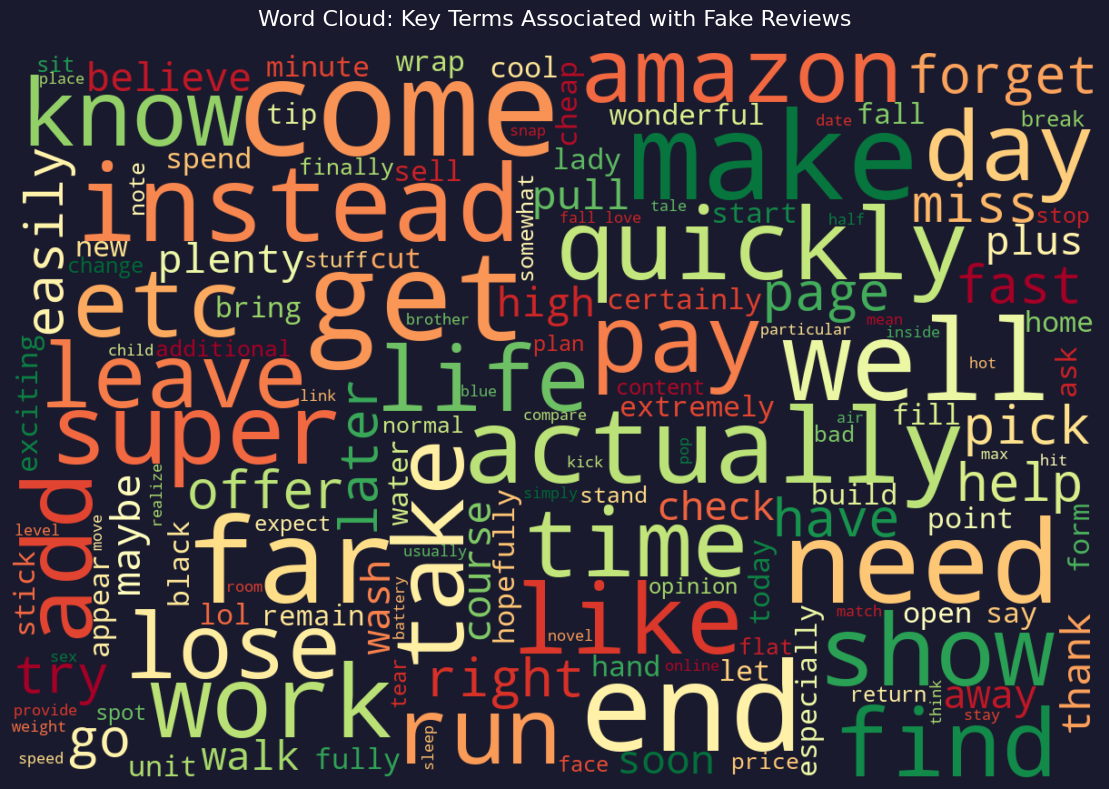

In [48]:
# Generate a single comprehensive Word Cloud for fake reviews
plt.figure(figsize=(12, 8))

# Combine both methods for better word cloud
combined_importance = {}
for word in fake_word_importance:
    if word in importance_dict:
        # Combine TF-IDF difference with model importance
        combined_importance[word] = fake_word_importance[word] * importance_dict.get(word, 0)

# If combined is empty, use fake_word_importance
if not combined_importance:
    combined_importance = fake_word_importance

wordcloud_combined = WordCloud(
    width=1200, height=800,
    background_color='#1a1a2e',
    colormap='RdYlGn_r',  # Red for high, green for low
    max_words=150,
    max_font_size=150,
    random_state=SEED
).generate_from_frequencies(combined_importance)

plt.imshow(wordcloud_combined, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Key Terms Associated with Fake Reviews', fontsize=16, color='white', pad=20)
plt.gca().set_facecolor('#1a1a2e')
plt.gcf().set_facecolor('#1a1a2e')
plt.tight_layout()
plt.savefig('fake_reviews_wordcloud_combined.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()

## Word Cloud Interpretation

### Observed Patterns in Fake Reviews

The word clouds reveal several interesting patterns that distinguish fake reviews from genuine ones:

**1. Exaggerated Positive Language**
- Fake reviews often contain overly enthusiastic and generic positive terms
- Words like "amazing", "perfect", "excellent", "best" appear frequently
- These superlatives are used to artificially boost product perception

**2. Vague Descriptors**
- Terms that lack specificity about the product's actual features
- Generic phrases that could apply to any product
- Absence of detailed, technical language

**3. Emotional Appeal**
- Words designed to create emotional connection rather than inform
- Focus on feelings rather than product functionality

**4. Common Red Flags**
- Repetitive phrases that appear unnaturally
- Marketing-style language patterns
- Unusual word combinations not typical in organic reviews

### Why These Patterns Indicate Fake Reviews

1. **Authenticity Gap**: Real customers typically describe specific experiences and product details, while fake reviews rely on generic positive statements.

2. **Writing Style**: Fake reviews often follow templates or are generated in bulk, leading to recognizable linguistic patterns.

3. **Motivation Difference**: Genuine reviewers want to inform other buyers; fake reviewers aim to manipulate purchase decisions.

---
# Summary and Results
---

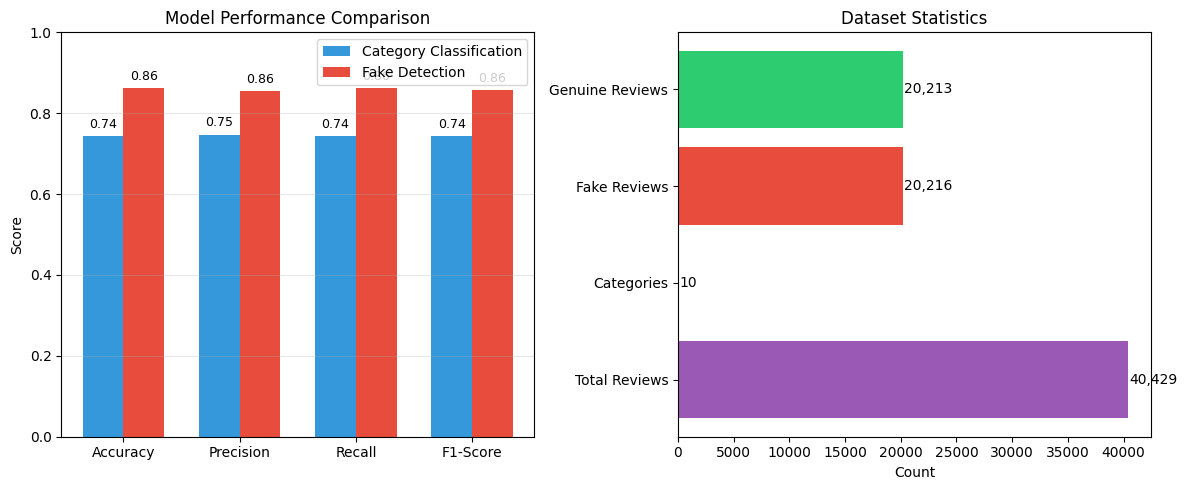

In [49]:
# Create summary visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Metrics comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
cat_values = [cat_metrics['accuracy'], cat_metrics['precision'], cat_metrics['recall'], cat_metrics['f1']]
fake_values = [fake_metrics['accuracy'], fake_metrics['precision'], fake_metrics['recall'], fake_metrics['f1']]

x = np.arange(len(metrics_names))
width = 0.35

axes[0].bar(x - width/2, cat_values, width, label='Category Classification', color='#3498db')
axes[0].bar(x + width/2, fake_values, width, label='Fake Detection', color='#e74c3c')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (c, f) in enumerate(zip(cat_values, fake_values)):
    axes[0].annotate(f'{c:.2f}', xy=(i - width/2, c + 0.02), ha='center', fontsize=9)
    axes[0].annotate(f'{f:.2f}', xy=(i + width/2, f + 0.02), ha='center', fontsize=9)

# Dataset statistics
stats_labels = ['Total Reviews', 'Categories', 'Fake Reviews', 'Genuine Reviews']
stats_values = [len(df), num_categories, len(df[df['label'] == 'OR']), len(df[df['label'] == 'CG'])]

colors = ['#9b59b6', '#1abc9c', '#e74c3c', '#2ecc71']
bars = axes[1].barh(stats_labels, stats_values, color=colors)
axes[1].set_xlabel('Count')
axes[1].set_title('Dataset Statistics')

for bar, val in zip(bars, stats_values):
    axes[1].annotate(f'{val:,}', xy=(val + 100, bar.get_y() + bar.get_height()/2),
                     va='center', fontsize=10)

plt.tight_layout()
plt.savefig('summary_results.png', dpi=150, bbox_inches='tight')
plt.show()

In [50]:
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

print(f"\n📊 Dataset:")
print(f"   Total reviews: {len(df):,}")
print(f"   Product categories: {num_categories}")
print(f"   Features (TF-IDF): {input_dim:,}")

print(f"\n🎯 Task 1 - Category Classification:")
print(f"   Accuracy:  {cat_metrics['accuracy']:.4f}")
print(f"   F1-Score:  {cat_metrics['f1']:.4f}")

print(f"\n🔍 Task 2 - Fake Review Detection:")
print(f"   Accuracy:  {fake_metrics['accuracy']:.4f}")
print(f"   F1-Score:  {fake_metrics['f1']:.4f}")

print(f"\n☁️ Task 3 - Word Cloud:")
print(f"   Generated visualizations saved to:")
print(f"   - fake_reviews_wordcloud.png")
print(f"   - fake_reviews_wordcloud_combined.png")

print(f"\n📁 All Generated Visualizations:")
visualizations = [
    "data_distribution.png",
    "category_training_curves.png",
    "category_confusion_matrix.png",
    "fake_detection_training_curves.png",
    "fake_detection_confusion_matrix.png",
    "fake_reviews_wordcloud.png",
    "fake_reviews_wordcloud_combined.png",
    "summary_results.png"
]
for viz in visualizations:
    print(f"   ✓ {viz}")

print("\n" + "="*60)
print("NOTEBOOK EXECUTION COMPLETE")
print("="*60)


FINAL SUMMARY

📊 Dataset:
   Total reviews: 40,429
   Product categories: 10
   Features (TF-IDF): 5,000

🎯 Task 1 - Category Classification:
   Accuracy:  0.7438
   F1-Score:  0.7446

🔍 Task 2 - Fake Review Detection:
   Accuracy:  0.8612
   F1-Score:  0.8583

☁️ Task 3 - Word Cloud:
   Generated visualizations saved to:
   - fake_reviews_wordcloud.png
   - fake_reviews_wordcloud_combined.png

📁 All Generated Visualizations:
   ✓ data_distribution.png
   ✓ category_training_curves.png
   ✓ category_confusion_matrix.png
   ✓ fake_detection_training_curves.png
   ✓ fake_detection_confusion_matrix.png
   ✓ fake_reviews_wordcloud.png
   ✓ fake_reviews_wordcloud_combined.png
   ✓ summary_results.png

NOTEBOOK EXECUTION COMPLETE
